In [218]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Workflow:
1. Gather data
2. Turn data intonumbers and tensors
3. stuff into nn
4. fit model
5. check the result
6. enjoy!

In [219]:
# Create known parameters

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
Y = weight * X + bias

X[:10], Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets

data - 100

training set
validation set ~~not always
test set

usually Train/Test 80/20 - the most common
or Train/Validation/Test 60/20/20 / 80/10/10

In [220]:
# Create a train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# train_split = int(0.8 * len(X))
# X_train, Y_train = X[:train_split], Y[:train_split]

# X_test, Y_test = X[train_split:], Y[train_split:] 

len(X_train), len(X_test)

(40, 10)

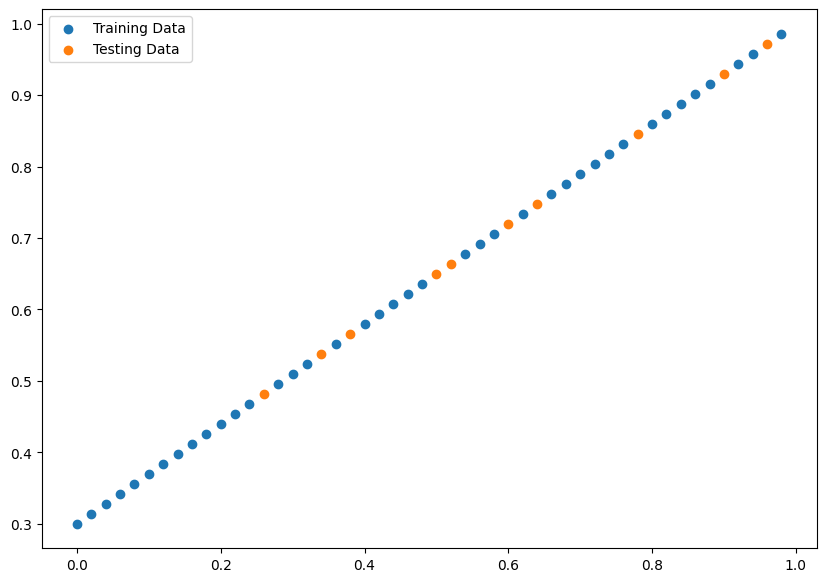

In [221]:
def plot_predition(train_data = X_train,
                   train_labels = Y_train,
                   test_data = X_test,
                   test_labels = Y_test,
                   predictions = None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, label='Training Data')
  plt.scatter(test_data, test_labels, label='Testing Data')
  if predictions is not None:
      plt.scatter(test_data, predictions, label='Predictions')
  plt.legend()
  plt.show()

plot_predition()


Start with random values (weight & bias)
Look at training data and adjust the random values to better represent(or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through 2 main algorithms:
1. Gradient descent
2. Brackpropagation

In [222]:
# Create a linear regression model class
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad = True,
                                            dtype = torch.float32))
    self.bias = nn.Parameter(torch.randn(1,
                                          requires_grad = True,
                                          dtype = torch.float32))  
  # forwar method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return x * self.weights + self.bias # linear regression formula


### Pytorch model building essentials

* torch.nn - contains all of the building glocks for computational graphs like neural networks
* torch.nn.Parameter - what parameters the model should try and learn, often a Pytorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward() method
* torch.optim - optimizer namespace
* def forward() - all torc models needs you to update this method

* torch.utils.data.Dataset - represents a map between a key (label) and sample (features) pairs of your data. Stored in labels (much like the pd.dataframes I've used before)
* torch.utils.data.DataLoader - Creates an iterable over a torch Dataset, allows you to iterate through the data

### Checking the content of our pytorch model

we can check the parameters using .parameters

In [223]:
# create a random seed

torch.manual_seed(42)

# Instantiate the model, sub-class of nn.Module
model_0 = LinearRegression()

model_0
print(model_0)
list(model_0.parameters())

model_0.state_dict()

LinearRegression()


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [224]:
# making prediction using torch.inference_mode()
with torch.inference_mode(): 
    y_preds = model_0(X_test)


# for now it's just random values, let's train the model



## 3. train model

One way to measure how poor or how wrong the predictions are, we'll define the loss function (cost function/criterion)

* **Loss function** a function to measure how wrong the prediction is to the result
* **Optimizer** Takes the loss and adjusts the parameters

and specifically for pytorch we need:

* a training loop
* a testing loop

In [225]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [226]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (SGD)
lr = 0.01 # learning rate, how fast the model changes
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)

### Building a training loop in pytorch (and a test loop)

Steps we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward' -> from input to output layer, forward propagation)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards, calculations goes backwards throught the network to calc. gradience of each of the parameters with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to improve the loss (gradient)


In [227]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [228]:
# an epoch is one complete pass through the training data
epochs = 2000

#Track different metrics
epoch_count = []
loss_values = []
test_loss_values = []


# 0. loop through the data

for epoch in range(epochs):

  # set the model to training mode
  model_0.train()  # set all the parameters that require_grad to True
  # model_0.eval() # set all the parameters that require_grad to False
  # 1. forward pass
  Y_pred = model_0(X_train)
  # 2. calculate the loss
  loss = loss_fn(Y_pred, Y_train)
  # 3. optimize zero grad
  optimizer.zero_grad()
  # 4. backward pass
  loss.backward()
  # 5. update the model, Step the optimizer
  optimizer.step()

  ### test the model
  model_0.eval() # turns off the different settings in the model not needed for evaluation
  with torch.inference_mode(): # turns off the gradient tracking


    # 1 forward pass on the test data
    Y_test_pred = model_0(X_test)

    #2. calculate the test loss value
    test_loss = loss_fn(Y_test_pred, Y_test)



  # print the loss
  if (epoch + 1) % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    print(f'Epoch: {epoch + 1} | loss: {loss.item():.4f} | Test loss: {test_loss.item():.4f}')
    print(model_0.state_dict())



Epoch: 10 | loss: 0.2308 | Test loss: 0.2574
OrderedDict({'weights': tensor([0.3832]), 'bias': tensor([0.2288])})
Epoch: 20 | loss: 0.1121 | Test loss: 0.1331
OrderedDict({'weights': tensor([0.4297]), 'bias': tensor([0.3258])})
Epoch: 30 | loss: 0.0661 | Test loss: 0.0647
OrderedDict({'weights': tensor([0.4707]), 'bias': tensor([0.3728])})
Epoch: 40 | loss: 0.0524 | Test loss: 0.0426
OrderedDict({'weights': tensor([0.5026]), 'bias': tensor([0.3868])})
Epoch: 50 | loss: 0.0460 | Test loss: 0.0344
OrderedDict({'weights': tensor([0.5272]), 'bias': tensor([0.3833])})
Epoch: 60 | loss: 0.0404 | Test loss: 0.0300
OrderedDict({'weights': tensor([0.5486]), 'bias': tensor([0.3733])})
Epoch: 70 | loss: 0.0348 | Test loss: 0.0256
OrderedDict({'weights': tensor([0.5701]), 'bias': tensor([0.3633])})
Epoch: 80 | loss: 0.0292 | Test loss: 0.0212
OrderedDict({'weights': tensor([0.5915]), 'bias': tensor([0.3533])})
Epoch: 90 | loss: 0.0236 | Test loss: 0.0168
OrderedDict({'weights': tensor([0.6130]), '

Epoch: 410 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 420 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 430 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 440 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 450 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 460 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 470 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 480 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.7039]), 'bias': tensor([0.3093])})
Epoch: 490 | loss: 0.0010 | Test loss: 0.0116
OrderedDict({'weights': tensor([0.

Text(0, 0.5, 'Loss')

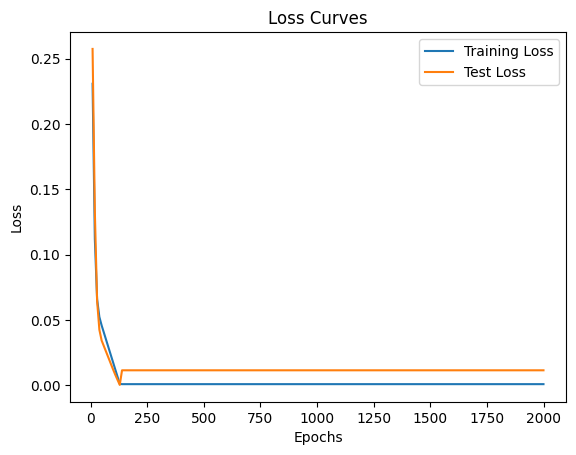

In [229]:
#plot the loss curves
plt.plot(epoch_count, loss_values, label = 'Training Loss')
plt.plot(epoch_count, test_loss_values, label = 'Test Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [230]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7039])), ('bias', tensor([0.3093]))])

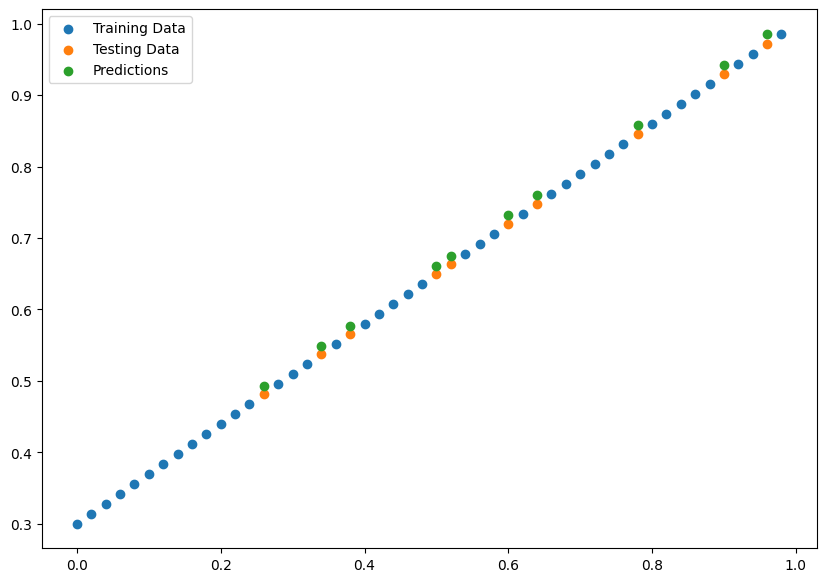

In [231]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  
plot_predition(predictions=y_preds_new.detach().numpy())

## save/load a model

There are three main methods for saving and loading a model in pytorch

1. torch.save() allows you to save pytorch object in a python's pickle format
2. torch.load() allows you to load pytorch object in a pyton's pickle format
3. torch.nn.Module.load_state_dict() - this allows you to load a model's state dictionary, tht is, the value of all parameters.

In [232]:
from pathlib import Path

# Create a directory to save the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

# Save the model
MODEL_NAME = "01_pytorch_workflow_model.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [233]:
#load the model
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

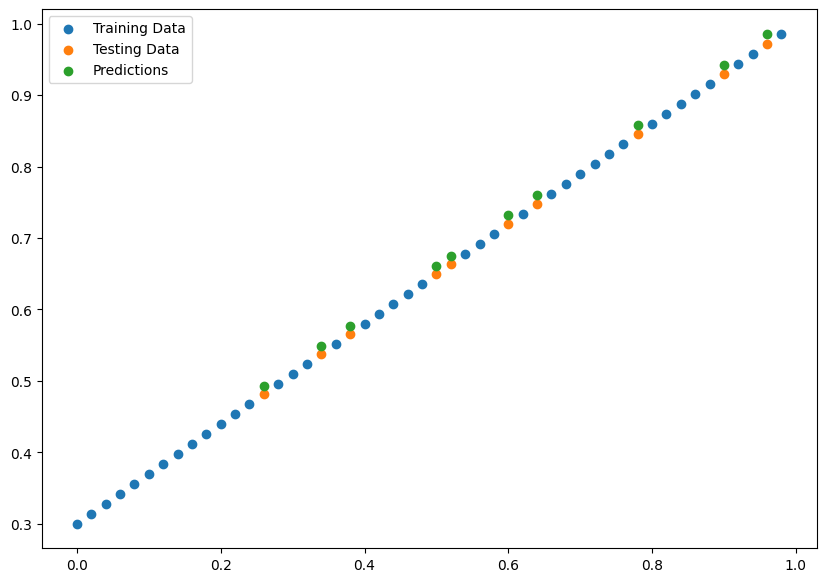

In [234]:
# print the loaded model and make predictions

loaded_model.state_dict()

loaded_model.eval() # set the model to evaluation mode
with torch.inference_mode():
  y_preds_loaded = loaded_model(X_test)

plot_predition(predictions=y_preds_loaded.detach().numpy())

## Putting it all backl together

Let's go back and go through the neccesary steps

In [235]:
# Import libraries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# check PyTorch version
print(torch.__version__)

2.2.0+cpu


Create device-agnostic code
If we've got a gpu avaible, we'll use it
Here, if cude is avaible, well use it, otherwise device == "cpu"

In [236]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using device: {device}')

using device: cpu


tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.8000],
        [0.7940],
        [0.7880],
        [0.7820],
        [0.7760],
        [0.7700],
        [0.7640],
        [0.7580],
        [0.7520],
        [0.7460]])
torch.Size([50, 1]) torch.Size([50, 1])


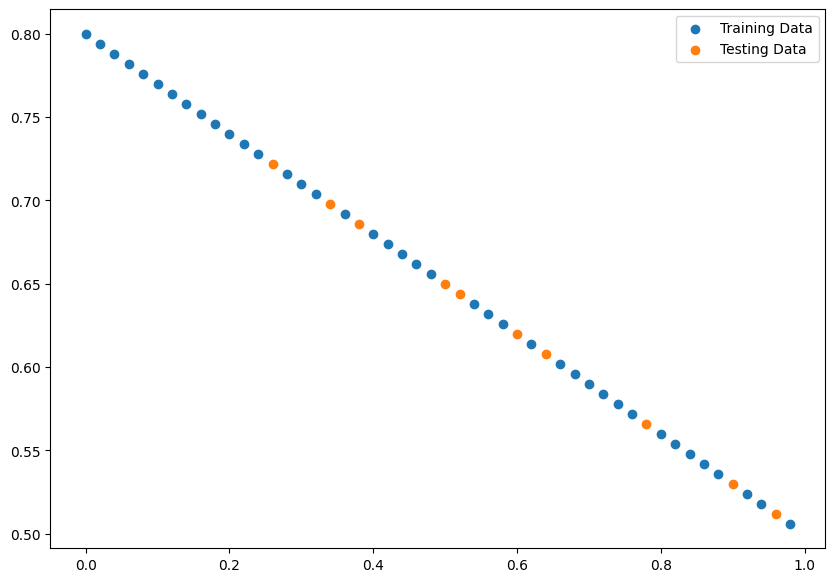

In [250]:
# create dummy dataset
weight = -0.3
bias = 0.8

start = 0
end = 1
step = 0.02

#create the data
X = torch.arange(start, end, step).unsqueeze(dim = 1)
Y = weight * X + bias

print(X[:10], Y[:10])
print(X.shape, Y.shape)
# Create a train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#plot the data

plt.figure(figsize=(10, 7))
plt.scatter(X_train, Y_train, label='Training Data')
plt.scatter(X_test, Y_test, label='Testing Data')
plt.legend()
plt.show()

### Building a PyTorch linear model

In [238]:
# Create a linear regression model class

class LinearRegression_2(nn.Module):
  def __init__(self):
    super().__init__()
    # define the layers - here linear layer, one input and one output
    self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

     
  # forwar method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [239]:
torch.manual_seed(42)
model_1 = LinearRegression_2()
model_1, model_1.state_dict()

(LinearRegression_2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### for training we need 
1. Loss function
2. Optimizer
3. Training loop
4, Testing loop

In [240]:
# create the loss function
loss_fn = nn.L1Loss()

# create the optimizer
lr = 0.001
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.001)

# Train the model
torch.manual_seed(42)
epochs = 5000

#Track different metrics
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  # set the model to training mode
  model_1.train()
  # 1. forward pass
  Y_pred = model_1(X_train)
  # 2. calculate the loss
  loss = loss_fn(Y_pred, Y_train)
  # 3. optimize zero grad
  optimizer.zero_grad()
  # 4. backward pass
  loss.backward()
  # 5. update the model, Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval() # turns off the different settings in the model not needed for evaluation
  with torch.inference_mode(): # turns off the gradient tracking
    # 1 forward pass on the test data
    Y_test_pred = model_1(X_test)
    #2. calculate the test loss value
    test_loss = loss_fn(Y_test_pred, Y_test)

  # print the loss
  if (epoch + 1) % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    print(f'Epoch: {epoch + 1} | loss: {loss.item():.4f} | Test loss: {test_loss.item():.4f}')
    print(model_1.state_dict())


Epoch: 10 | loss: 0.5146 | Test loss: 0.6432
OrderedDict({'linear_layer.weight': tensor([[0.7599]]), 'linear_layer.bias': tensor([0.8200])})
Epoch: 20 | loss: 0.5024 | Test loss: 0.6305
OrderedDict({'linear_layer.weight': tensor([[0.7552]]), 'linear_layer.bias': tensor([0.8100])})
Epoch: 30 | loss: 0.4903 | Test loss: 0.6177
OrderedDict({'linear_layer.weight': tensor([[0.7506]]), 'linear_layer.bias': tensor([0.8000])})
Epoch: 40 | loss: 0.4789 | Test loss: 0.6055
OrderedDict({'linear_layer.weight': tensor([[0.7459]]), 'linear_layer.bias': tensor([0.7905])})
Epoch: 50 | loss: 0.4677 | Test loss: 0.5932
OrderedDict({'linear_layer.weight': tensor([[0.7413]]), 'linear_layer.bias': tensor([0.7810])})
Epoch: 60 | loss: 0.4572 | Test loss: 0.5814
OrderedDict({'linear_layer.weight': tensor([[0.7366]]), 'linear_layer.bias': tensor([0.7719])})
Epoch: 70 | loss: 0.4469 | Test loss: 0.5697
OrderedDict({'linear_layer.weight': tensor([[0.7320]]), 'linear_layer.bias': tensor([0.7629])})


Epoch: 80 | loss: 0.4371 | Test loss: 0.5582
OrderedDict({'linear_layer.weight': tensor([[0.7273]]), 'linear_layer.bias': tensor([0.7541])})
Epoch: 90 | loss: 0.4277 | Test loss: 0.5470
OrderedDict({'linear_layer.weight': tensor([[0.7227]]), 'linear_layer.bias': tensor([0.7456])})
Epoch: 100 | loss: 0.4184 | Test loss: 0.5358
OrderedDict({'linear_layer.weight': tensor([[0.7181]]), 'linear_layer.bias': tensor([0.7372])})
Epoch: 110 | loss: 0.4099 | Test loss: 0.5251
OrderedDict({'linear_layer.weight': tensor([[0.7135]]), 'linear_layer.bias': tensor([0.7292])})
Epoch: 120 | loss: 0.4014 | Test loss: 0.5144
OrderedDict({'linear_layer.weight': tensor([[0.7089]]), 'linear_layer.bias': tensor([0.7212])})
Epoch: 130 | loss: 0.3934 | Test loss: 0.5041
OrderedDict({'linear_layer.weight': tensor([[0.7043]]), 'linear_layer.bias': tensor([0.7136])})
Epoch: 140 | loss: 0.3857 | Test loss: 0.4939
OrderedDict({'linear_layer.weight': tensor([[0.6998]]), 'linear_layer.bias': tensor([0.7061])})
Epoch: 1

Text(0.5, 1.0, 'Loss Curves')

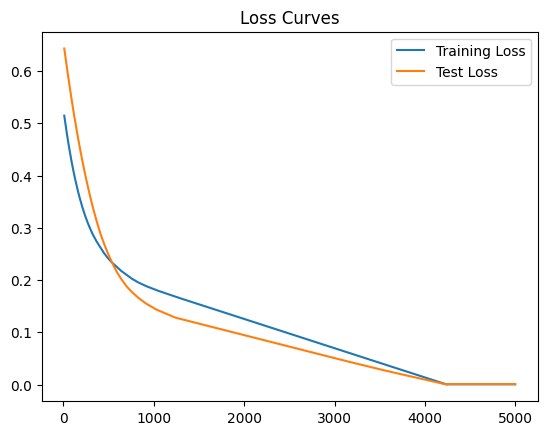

In [241]:
# plot the loss curves and the predictions

plt.plot(epoch_count, loss_values, label = 'Training Loss')
plt.plot(epoch_count, test_loss_values, label = 'Test Loss')
plt.legend()
plt.title('Loss Curves')

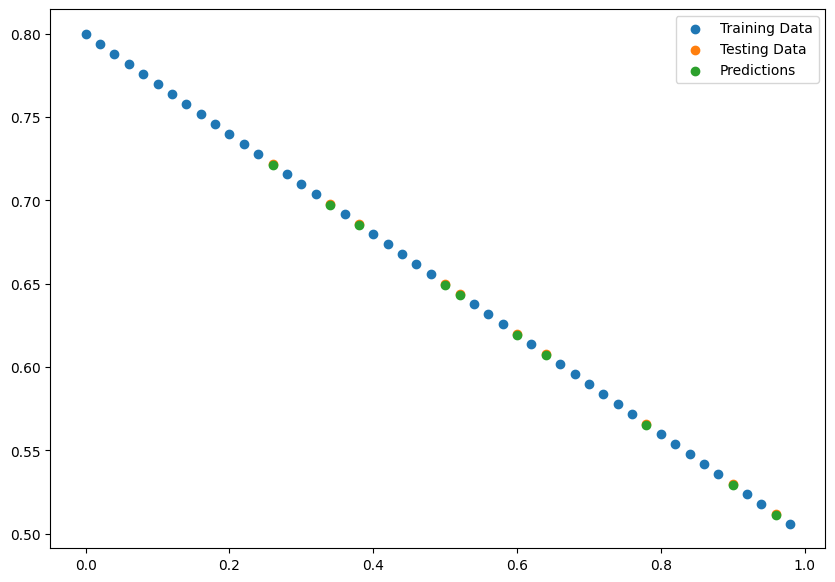

In [242]:
# predict the test data

model_1.eval() # set the model to evaluation mode

with torch.inference_mode():
  y_preds_new_2 = model_1(X_test)

# plot the predictions 
plt.figure(figsize=(10, 7))
plt.scatter(X_train, Y_train, label='Training Data')
plt.scatter(X_test, Y_test, label='Testing Data')
plt.scatter(X_test, y_preds_new_2.detach().numpy(), label='Predictions')
plt.legend()
plt.show()

In [243]:
#save the model 
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

MODEL_NAME = "02_pytorch_workflow_model.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_1.state_dict(), MODEL_SAVE_PATH)



In [249]:
# Make point predictions with the model

# Load the model
loaded_model = LinearRegression_2()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# print the loaded model and make predictions
loaded_model.state_dict()

loaded_model.eval() # set the model to evaluation mode
with torch.inference_mode():
  x = torch.tensor([2.0])
  y = loaded_model(x)
  print(y)

  print (f'Prediction for x = {x.item()} is y = {y.item()}')
  print (f'weight: {weight} | bias: {bias}')
  print(f'-2 * weight + bias = {weight * 2 + bias}')

tensor([0.1986])
Prediction for x = 2.0 is y = 0.198638916015625
weight: -0.3 | bias: 0.8
-2 * weight + bias = 0.20000000000000007
